# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Vicente Sebastian Serrano Cabrera

**Professor**: Pablo Camarillo Ramirez

# Introduction

## Introducción

En juegos competitivos como *Valorant*, se generan múltiples eventos en tiempo real durante cada partida: movimientos, disparos, habilidades, objetivos, etc. Manejar esta gran cantidad de datos simultáneos es un reto, ya que si no se procesan y almacenan correctamente, se pierde información valiosa para el análisis del rendimiento, mejoras del matchmaking y detección de trampas.

El objetivo de este proyecto es implementar una parte del pipeline propuesto previamente: limpiar y transformar datos de telemetría con Apache Spark, y posteriormente persistir la información procesada en una base de datos PostgreSQL. Con esto se busca asegurar que los datos estén organizados, completos y disponibles para futuros análisis y visualizaciones.


In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final Project: Batch Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "5")

25/10/26 19:09:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Dataset

In [2]:
valorant_df = spark.read \
                .option("header", "true") \
                .csv("/opt/spark/work-dir/data/valorant_events.csv", header=True, inferSchema=True)

valorant_df.printSchema()

root
 |-- event_id: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- player_name: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- map_name: string (nullable = true)
 |-- game_mode: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- weapon_or_ability: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)



# Transformations and Actions

In [3]:
from pyspark.sql.functions import col, to_date, hour, when, count, avg

valorant_df = valorant_df.withColumn("event_date", to_date(col("timestamp"))) \
                         .withColumn("event_hour", hour(col("timestamp"))) \
                         .withColumn("critical_event", 
                                     when(col("event_type").isin(["Kill", "SpikePlant", "SpikeDefuse"]), 1)
                                     .otherwise(0))

valorant_df_clean = valorant_df.dropna(subset=["player_id", "match_id", "event_type", "timestamp"]) \
                               .dropDuplicates()

df_player_stats = valorant_df_clean.groupBy("player_id", "player_name", "rank") \
                                   .agg(count("critical_event").alias("total_critical_events"))

df_map_stats = valorant_df_clean.groupBy("map_name") \
                                .agg(avg("critical_event").alias("avg_critical_events"))




# Persistence Data

### Justificación de la selección de la base de datos

Para la persistencia de los datos transformados se seleccionó PostgreSQL debido a 2 motivos, el primero es que fue el usado duarente las clases y el conocido para implementar, mientras que el segundo motivo es que el modelo de información del proyecto está altamente estructurado y presenta relaciones claras entre entidades como jugadores, partidas, mapas y eventos dentro del juego Valorant. Este tipo de datos se adapta mejor a un esquema relacional, donde la consistencia, normalización y capacidad para realizar consultas analíticas son esenciales.

PostgreSQL nos permite:
- Mantener integridad referencial entre los datos de telemetría procesados.
- Ejecutar consultas SQL complejas para obtener métricas del desempeño de jugadores o balance de mapas.
- Escalar el almacenamiento sin perder consistencia y fiabilidad en la información.
- Integrarse fácilmente con Spark mediante conexión JDBC para cargas y actualizaciones periódicas.




In [4]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

valorant_df_clean.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "valorant_clean") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("valorant_clean guardado")

df_player_stats.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "valorant_player_stats") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("valorant_player_stats guardado")

df_map_stats.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "valorant_map_stats") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("valorant_map_stats guardado")


valorant_clean guardado
valorant_player_stats guardado
valorant_map_stats guardado


# DAG

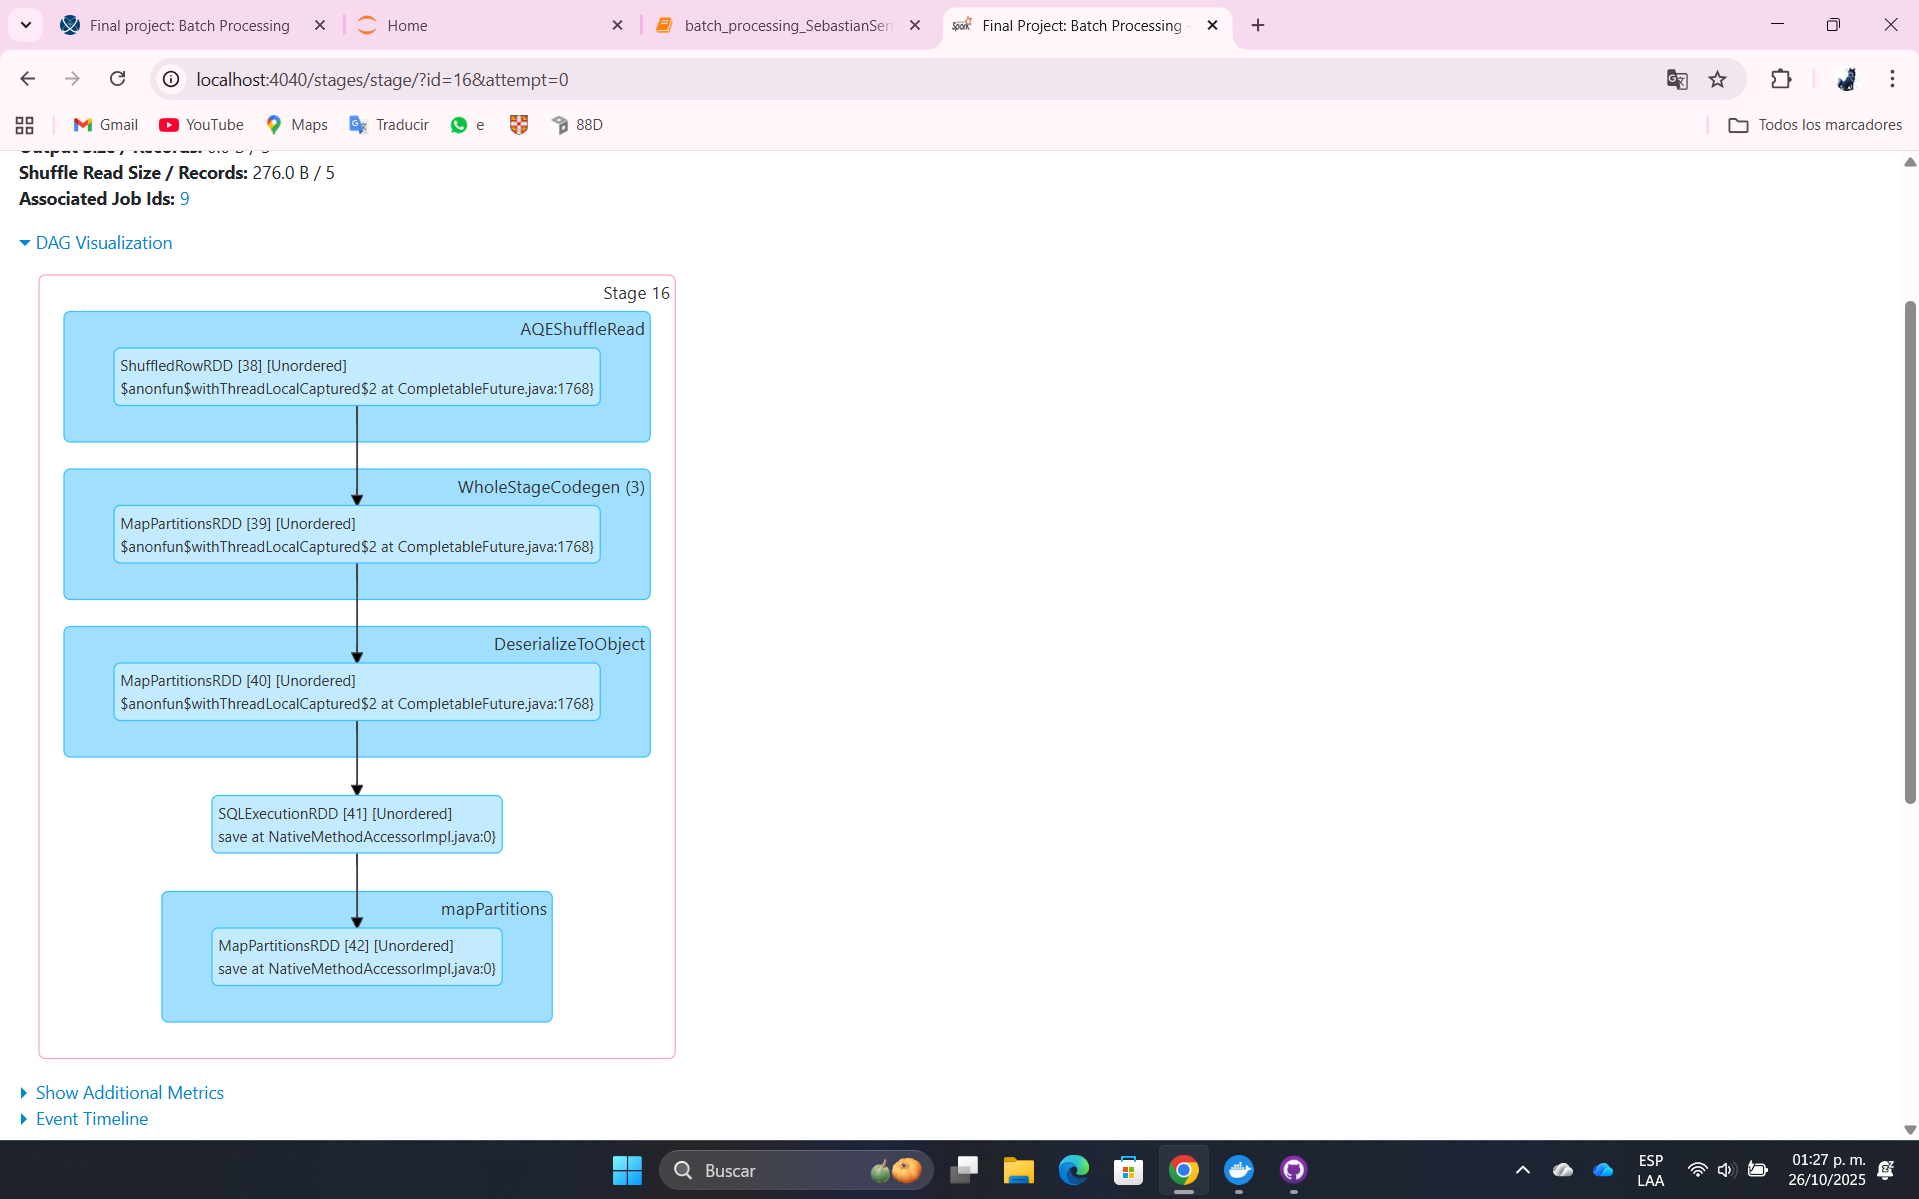

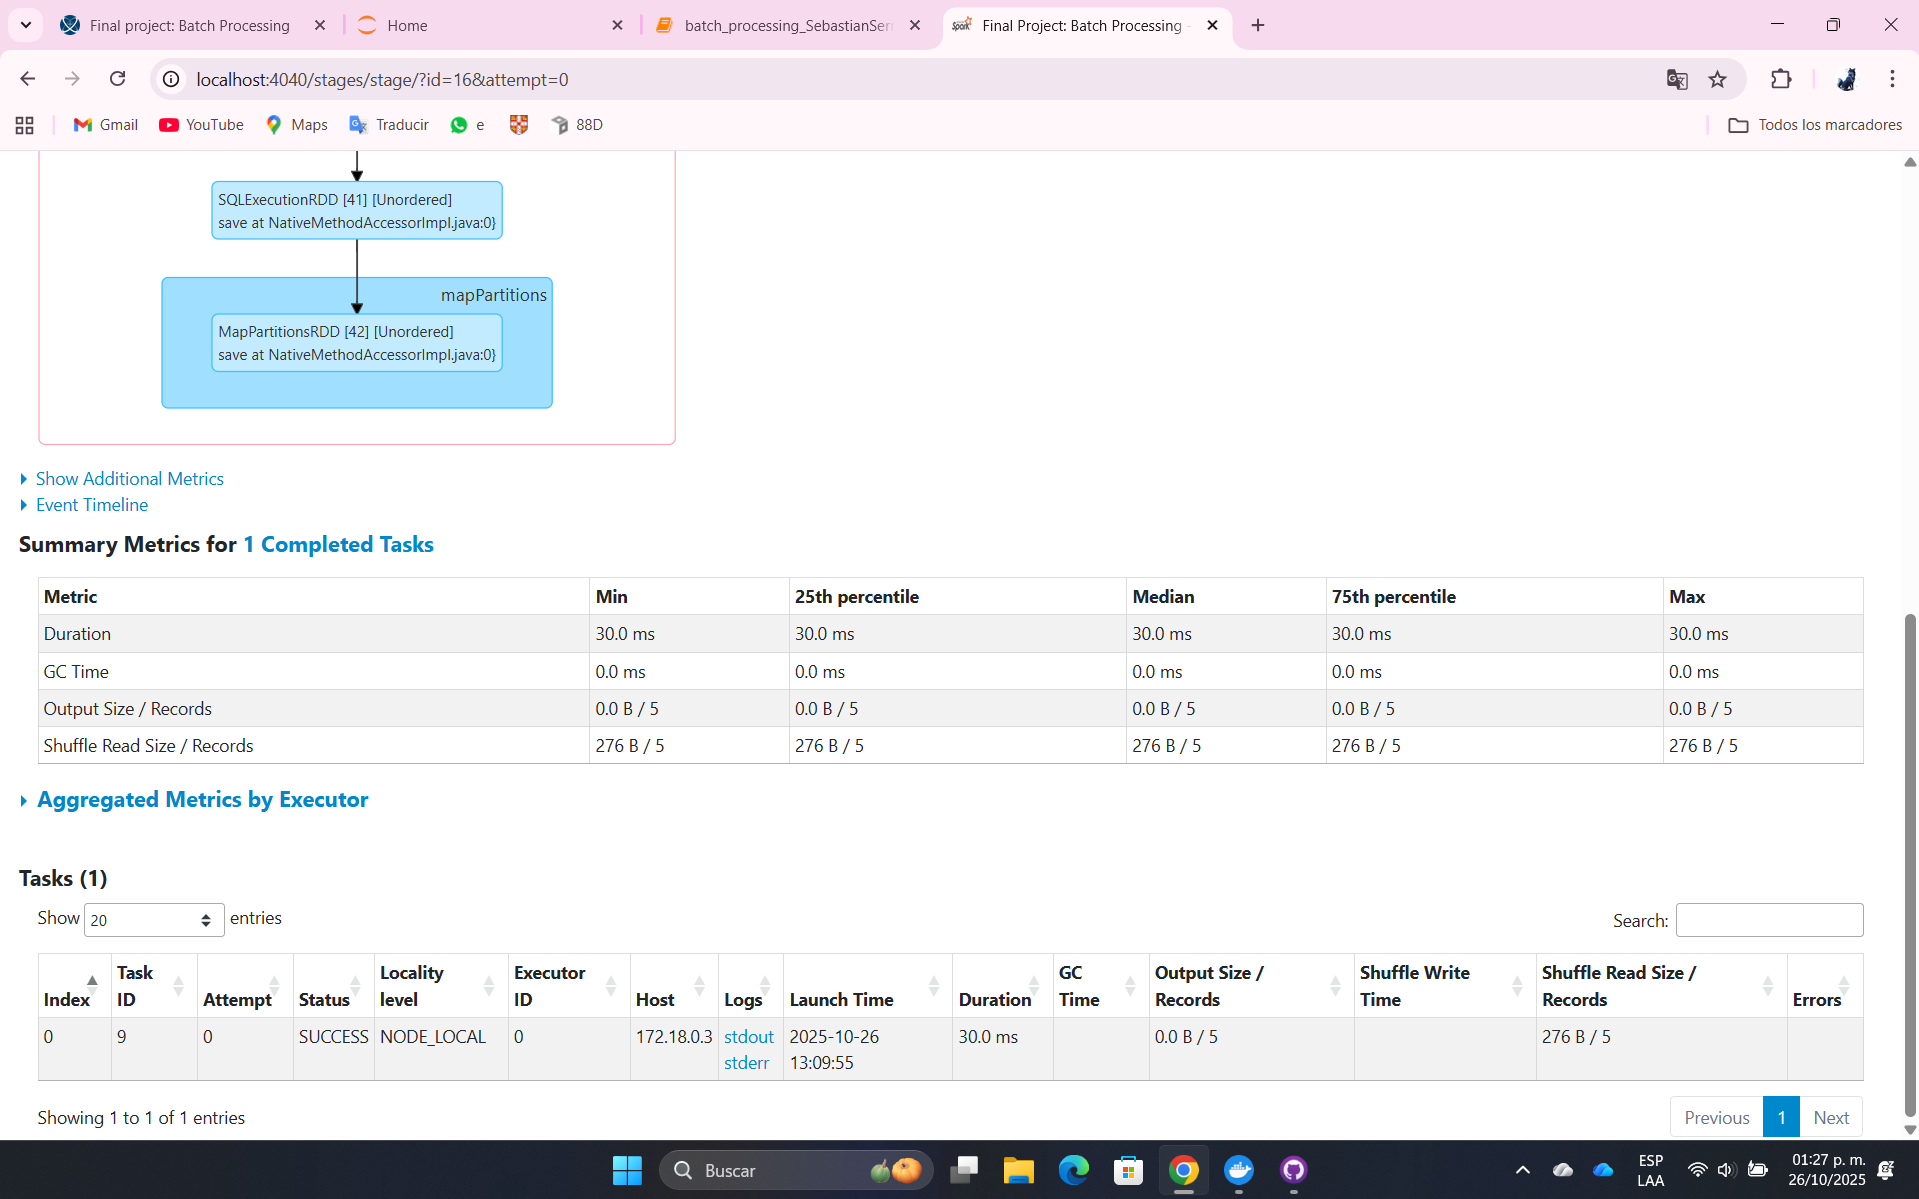

In [5]:
sc.stop()